# American Option Pricing

This notebook implements **American Call and Put option pricing**

Import Librabries

In [242]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from numpy.polynomial.laguerre import lagval
from scipy.interpolate import interp1d
from scipy.linalg import solve_banded


### 1. American Option Pricing Using the CRR Binomial Tree
We will first implement an object-oriented approach to price American call and put options using the **Cox-Ross-Rubinstein (CRR) binomial tree** model. The model accounts for **early exercise** and applies **backward induction** for valuation.


#### Define the Pricing Class

In [10]:
class AmericanOptionCRR:
    def __init__(self, S0, K, T, r, sigma, n_steps, option_type="put"):
        """
        Initialize the parameters for the American Option using CRR Binomial Tree.

        Parameters:
        - S0 (float) : Initial stock price
        - K (float) : Strike price
        - T (float) : Time to maturity (in years)
        - r (float) : Risk-free interest rate (annualized)
        - sigma (float) : Volatility (annualized)
        - n_steps (int) : Number of binomial time steps
        - option_type (str) : 'call' or 'put'
        """
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.n_steps = n_steps
        self.dt = T / n_steps
        self.option_type = option_type.lower() #lower case option type

        # CRR parameters
        self.u = np.exp(sigma * np.sqrt(self.dt))     # up factor
        self.d = 1 / self.u                           # down factor
        self.p = (np.exp(r * self.dt) - self.d) / (self.u - self.d)  # risk-neutral probability
        self.discount = np.exp(-r * self.dt)          # to discount expected future values
    
    def _initialize_stock_tree(self):
        """
        Construct the binomial stock price tree.
        """
        stock_tree = np.zeros((self.n_steps + 1, self.n_steps + 1))
        for i in range(self.n_steps + 1):
            for j in range(i + 1):
                stock_tree[j, i] = self.S0 * (self.u ** (i - j)) * (self.d ** j)
        return stock_tree

    def _initialize_option_tree(self, stock_tree):
        """
        Compute terminal payoffs of the option.
        """
        option_tree = np.zeros_like(stock_tree)
        for j in range(self.n_steps + 1):
            if self.option_type == 'call':
                option_tree[j, self.n_steps] = max(stock_tree[j, self.n_steps] - self.K, 0)
            elif self.option_type == 'put':
                option_tree[j, self.n_steps] = max(self.K - stock_tree[j, self.n_steps], 0)
        return option_tree

    
    
    def price(self, track_exercise=False):
        """
        Price the American option and optionally track early exercise decision.
        """
        stock_tree = self._initialize_stock_tree()
        option_tree = self._initialize_option_tree(stock_tree)

        # Initialize a decision tree (1 = exercise, 0 = continue)
        if track_exercise:
            self.exercise_tree = np.zeros_like(option_tree)

        for i in reversed(range(self.n_steps)):
            for j in range(i + 1):
                continuation = (self.p * option_tree[j, i+1] +
                                (1 - self.p) * option_tree[j+1, i+1]) * self.discount

                if self.option_type == 'call':
                    exercise = max(stock_tree[j, i] - self.K, 0)
                elif self.option_type == 'put':
                    exercise = max(self.K - stock_tree[j, i], 0)

                option_tree[j, i] = max(exercise, continuation)

                if track_exercise and exercise > continuation:
                    self.exercise_tree[j, i] = 1  # Mark early exercise

        return option_tree[0, 0]



#### Compute Amercian Options price 

In [17]:
# Parameters
S0 = 100       # initial stock price
K = 100        # strike price
T = 1.0        # time to maturity (1 year)
r = 0.03       # risk-free rate (3%)
sigma = 0.2    # volatility (annualized)
n_steps = 500  # number of time steps

# American Put
american_put = AmericanOptionCRR(S0, K, T, r, sigma, n_steps, option_type='put')
price_put = american_put.price()
print(f"American Put Option Price (CRR): {price_put:.4f}")

# American Call
american_call = AmericanOptionCRR(S0, K, T, r, sigma, n_steps, option_type='call')
price_call = american_call.price()
print(f"American Call Option Price (CRR): {price_call:.4f}")


American Put Option Price (CRR): 6.7411
American Call Option Price (CRR): 9.4094


#### Compute European Option Prices using Black-Scholes
We want to compute European option prices using Black-Scholes with the same paramteres to compare the results

In [18]:
def black_scholes_price(S0, K, T, r, sigma, option_type='call'):
    """
    Computes the Black-Scholes price for a European call or put option.
    
    Parameters:
    - S0: Initial stock price
    - K: Strike price
    - T: Time to maturity (in years)
    - r: Risk-free interest rate
    - sigma: Volatility (annualized)
    - option_type: 'call' or 'put'
    
    Returns:
    - Option price (float)
    """
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type.lower() == 'call':
        price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type.lower() == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    
    return price


#### Compare European Option prices with CRR American Prices

In [19]:
# European prices (Black-Scholes)
euro_put_price = black_scholes_price(S0, K, T, r, sigma, option_type='put')
euro_call_price = black_scholes_price(S0, K, T, r, sigma, option_type='call')
american_put_price = price_put
american_call_price = price_call
# Print results and comapre 
print(f"European Put Price (Black-Scholes): {euro_put_price:.4f}")
print(f"American Put Price (CRR): {american_put_price:.4f}")

print(f"European Call Price (Black-Scholes): {euro_call_price:.4f}")
print(f"American call Price (CRR): {american_call_price:.4f}")

print(f"Early Exercise Premium (Put): {american_put_price - euro_put_price:.4f}")
print(f"Early Exercise Premium (Call): {american_call_price - euro_call_price:.4f}")


European Put Price (Black-Scholes): 6.4580
American Put Price (CRR): 6.7411
European Call Price (Black-Scholes): 9.4134
American call Price (CRR): 9.4094
Early Exercise Premium (Put): 0.2831
Early Exercise Premium (Call): -0.0040


American Put is worth $0.2831 more than the European put due to early exercise flexibility.

American Call is slightly underpriced by $0.0040 (a small numerical error); early exercise is not optimal since the stock pays no dividends.

Results confirm expected behavior: early exercise adds value for puts but not for calls.


#### Convergence Analysis: American Option Price vs. Number of Steps


In [20]:
def convergence_plot(option_type='put', S0=100, K=100, T=1.0, r=0.03, sigma=0.2,
                     step_range=range(5, 500, 5), reference_price=None):
    """
    Plots American option prices using CRR for increasing n_steps.
    Optionally compares to a reference price (e.g., European price).
    """
    prices = []
    steps = []

    for n in step_range:
        option = AmericanOptionCRR(S0, K, T, r, sigma, n_steps=n, option_type=option_type)
        price = option.price()
        prices.append(price)
        steps.append(n)

    plt.figure(figsize=(10, 6))
    plt.plot(steps, prices, marker='o', label=f'American {option_type.title()} Price')
    
    if reference_price is not None:
        plt.axhline(reference_price, color='r', linestyle='--',
                    label=f'Reference ({option_type.title()} European Price)')

    plt.xlabel('Number of Time Steps (n_steps)')
    plt.ylabel('Option Price')
    plt.title(f'Convergence of CRR American {option_type.title()} Option Price')
    plt.legend()
    plt.grid(True)
    plt.show()


Run 

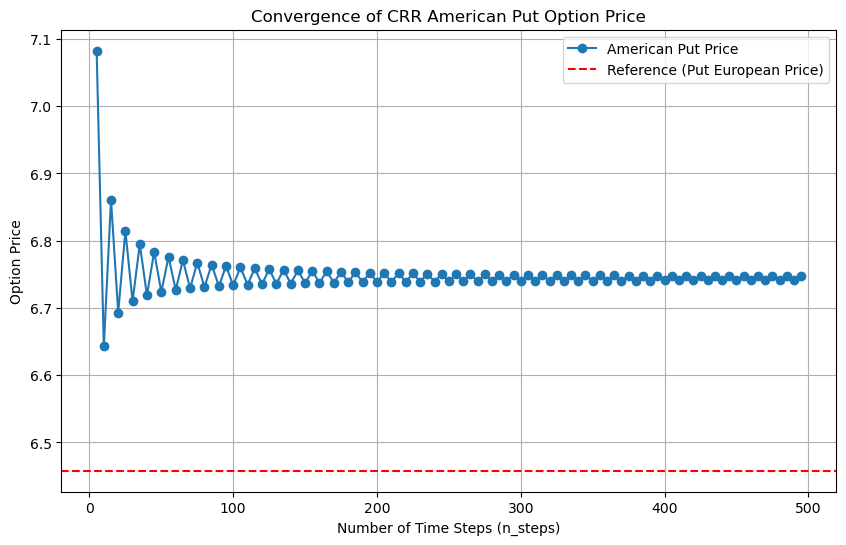

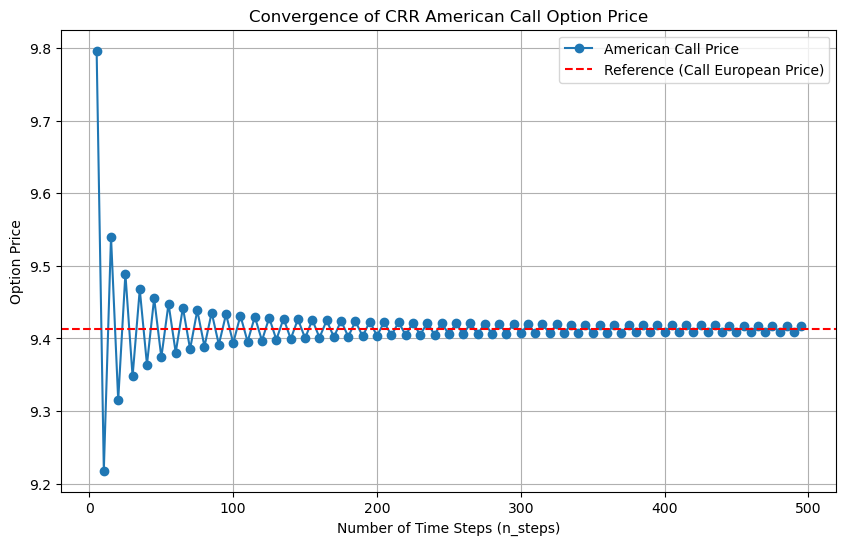

In [21]:
# Reference prices from Black-Scholes
european_put = black_scholes_price(S0, K, T, r, sigma, option_type='put')
european_call = black_scholes_price(S0, K, T, r, sigma, option_type='call')

# Convergence for American Put
convergence_plot(option_type='put', reference_price=european_put)

# Convergence for American Call
convergence_plot(option_type='call', reference_price=european_call)


#### Estimate the rate of convergence for the CRR binomial tree method.

In [22]:
def convergence_table(option_type='put', S0=100, K=100, T=1.0, r=0.03, sigma=0.2,
                      step_range=range(5, 500, 5)):
    prices = []
    steps = []

    for n in step_range:
        option = AmericanOptionCRR(S0, K, T, r, sigma, n_steps=n, option_type=option_type)
        price = option.price()
        steps.append(n)
        prices.append(price)

    df = pd.DataFrame({
        'n_steps': steps,
        f'American_{option_type}_price': prices
    })

    # Compute change from previous row (convergence behavior)
    df['Abs_Diff'] = df[f'American_{option_type}_price'].diff().abs()
    return df


In [24]:
# Generate and display convergence table for put option
convergence_df_put = convergence_table(option_type='put')
convergence_df_put


,n_steps,American_put_price,Abs_Diff
0,5,7.082382,NaN
1,10,6.642500,0.439881
2,15,6.860806,0.218306
3,20,6.692883,0.167923
4,25,6.814486,0.121603
...,...,...,...
94,475,6.746877,0.005915
95,480,6.741006,0.005872
96,485,6.746798,0.005793
97,490,6.741046,0.005752


In [25]:
# Generate and display convergence table for call option
convergence_df_call = convergence_table(option_type='call')
convergence_df_call

,n_steps,American_call_price,Abs_Diff
0,5,9.796472,NaN
1,10,9.217851,0.578621
2,15,9.539858,0.322007
3,20,9.314897,0.224962
4,25,9.489075,0.174178
...,...,...,...
94,475,9.417369,0.008185
95,480,9.409273,0.008097
96,485,9.417288,0.008015
97,490,9.409357,0.007931


Estimate Rate of Convergence: The CRR method converges at approximately O(1/n) — this means the error decreases linearly with step size. We can test this by regressing the log of absolute error against log(n_steps)


In [27]:
def estimate_convergence_rate(df, true_price=None, option_type='put'):
    """
    Estimate convergence rate by fitting log-log regression of error vs. n_steps.
    """
    if true_price is None:
        # Assume last value as reference if no true price is given
        true_price = df[f'American_{option_type}_price'].iloc[-1]

    df = df.copy()
    df['Error'] = (df[f'American_{option_type}_price'] - true_price).abs()

    # Drop zeros or NaNs to avoid log(0)
    df = df[df['Error'] > 1e-10]

    log_n = np.log(df['n_steps'].values).reshape(-1, 1)
    log_err = np.log(df['Error'].values).reshape(-1, 1)

    reg = LinearRegression().fit(log_n, log_err)
    rate = -reg.coef_[0, 0]  # negative slope

    print(f"Estimated convergence rate: O(1/n^{rate:.2f})")
    return rate


In [29]:
# Estimate convergence rate for put option
estimate_convergence_rate(convergence_df_put, option_type='put')


Estimated convergence rate: O(1/n^1.19)


np.float64(1.1907373047740282)

In [30]:
# Estimate convergence rate for call option
estimate_convergence_rate(convergence_df_call, option_type='call')

Estimated convergence rate: O(1/n^1.24)


np.float64(1.2388317568080283)

In [37]:
def plot_convergence_loglog(df, true_price=None, option_type='put'):
    """
    Plot log-log convergence of pricing error vs n_steps.
    """

    df = df.copy()

    # Use last value as reference if none provided
    if true_price is None:
        true_price = df[f'American_{option_type}_price'].iloc[-1]

    # Compute absolute error
    df['Error'] = (df[f'American_{option_type}_price'] - true_price).abs()
    df = df[df['Error'] > 1e-10]

    # Log values
    log_n = np.log(df['n_steps'].values).reshape(-1, 1)
    log_error = np.log(df['Error'].values).reshape(-1, 1)

    # Linear regression for slope
    reg = LinearRegression().fit(log_n, log_error)
    slope = reg.coef_[0][0]

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(log_n, log_error, 'o-', label='Log(Error) vs Log(n_steps)')
    plt.plot(log_n, reg.predict(log_n), 'r--', label=f'Fit: slope ≈ {slope:.2f}')
    plt.xlabel("log(n_steps)")
    plt.ylabel("log(Error)")
    plt.title(f"Convergence Rate of American {option_type.title()} Option (CRR)")
    plt.grid(True)
    plt.legend()
    plt.show()

    print(f"Visual slope (convergence rate exponent): {slope:.2f}")


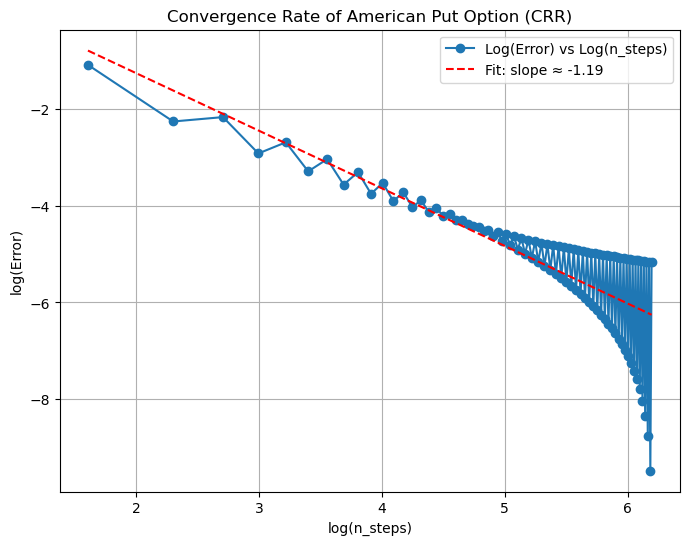

Visual slope (convergence rate exponent): -1.19


In [38]:
plot_convergence_loglog(convergence_df_put, option_type='put')


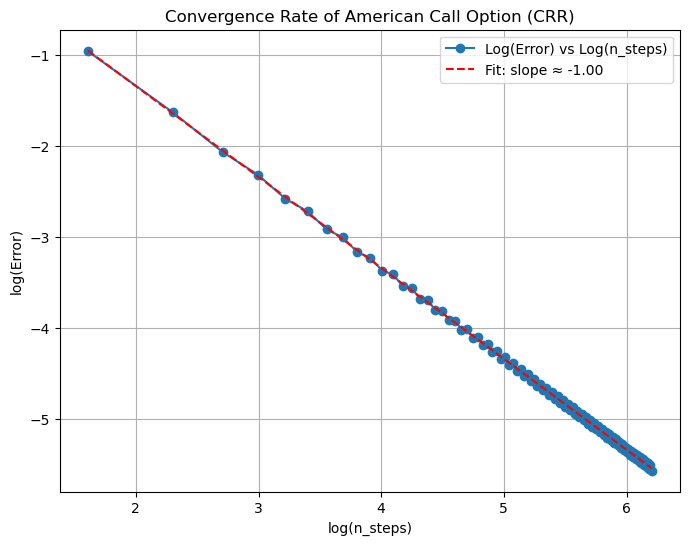

Visual slope (convergence rate exponent): -1.00


In [33]:
plot_convergence_loglog(convergence_df_call, true_price=european_call, option_type='call')


#### Visualize Early Exercise region

In [34]:
def visualize_early_exercise(option: AmericanOptionCRR):
    """
    Plot the early exercise region from the computed exercise_tree.
    """
    if not hasattr(option, "exercise_tree"):
        print("No early exercise data found. Run price(track_exercise=True) first.")
        return

    fig, ax = plt.subplots(figsize=(10, 6))
    x_vals = []
    y_vals = []

    for i in range(option.n_steps):
        for j in range(i + 1):
            if option.exercise_tree[j, i] == 1:
                x_vals.append(i)
                y_vals.append(option.S0 * (option.u ** (i - j)) * (option.d ** j))

    ax.scatter(x_vals, y_vals, color='red', label='Early Exercise Region', s=25)
    ax.set_title(f"Early Exercise Region for American {option.option_type.title()} Option")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Stock Price")
    ax.grid(True)
    ax.legend()
    plt.show()


#### Run for Put Option

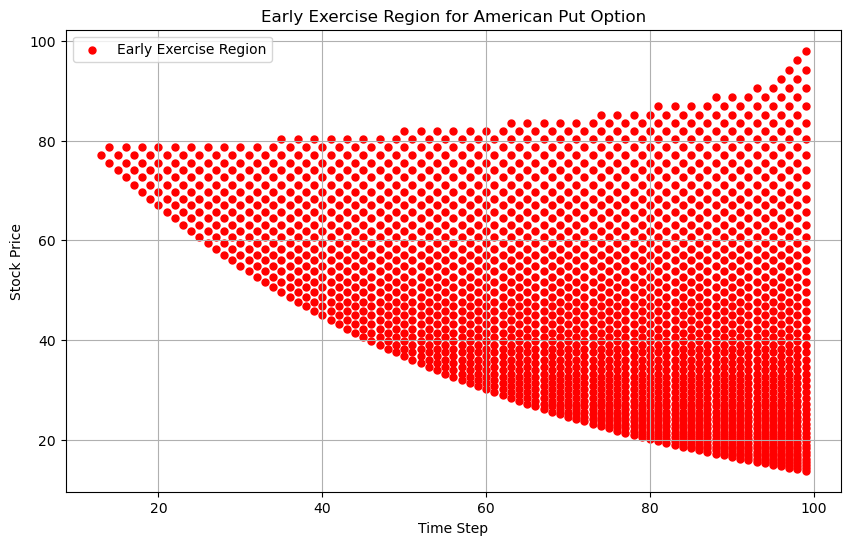

In [35]:
# Run pricing with tracking
american_put = AmericanOptionCRR(S0, K, T, r, sigma, n_steps=100, option_type='put')
american_put.price(track_exercise=True)

# Visualize early exercise nodes
visualize_early_exercise(american_put)


Run for American Call Option

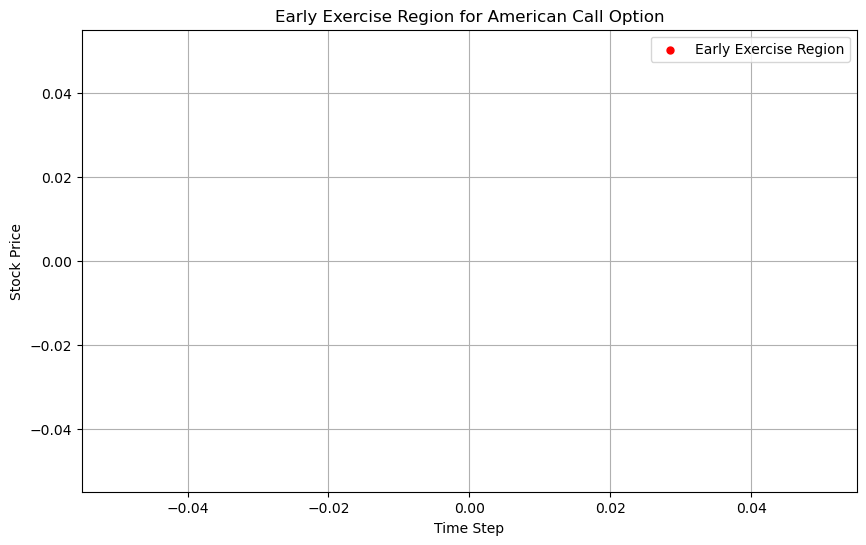

In [36]:
# Run pricing with tracking
american_call = AmericanOptionCRR(S0, K, T, r, sigma, n_steps=100, option_type='call')
american_call.price(track_exercise=True)

# Visualize early exercise nodes
visualize_early_exercise(american_call)

### 2. Trinomial Tree for American Options

In this part, we will price American call and put options (no dividend) using a Trinomial Tree which support early exercises with backward induction.

In [68]:
class AmericanOptionTrinomial:
    def __init__(self, S0, K, T, r, sigma, n_steps=100, option_type='put'):
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.n_steps = n_steps
        self.dt = T / n_steps
        self.option_type = option_type.lower()

        self.u = np.exp(sigma * np.sqrt(2 * self.dt)) # up factor 
        self.d = 1 / self.u  # down factor
        self.discount = np.exp(-r * self.dt)

        k = sigma * np.sqrt(self.dt / 2)
        alpha = np.exp(r * self.dt / 2)
        
        # Risk neutral probabilities 
        self.pu = ((alpha - np.exp(-k)) / (np.exp(k) - np.exp(-k))) ** 2
        self.pd = ((np.exp(k) - alpha) / (np.exp(k) - np.exp(-k))) ** 2
        self.pm = 1 - self.pu - self.pd

    def payoff(self, S):
        if self.option_type == 'call':
            return max(S - self.K, 0)
        else:
            return max(self.K - S, 0)

    def price(self):
        # Tree will have 2n+1 nodes in width and n+1 time steps
        size = 2 * self.n_steps + 1
        V = np.zeros((size, self.n_steps + 1))

        # Final stock prices and option values at maturity
        for i in range(size):
            j = i - self.n_steps
            ST = self.S0 * self.u ** j
            V[i, self.n_steps] = self.payoff(ST)

        # Backward induction
        for t in reversed(range(self.n_steps)):
            for i in range(t + 1, 2 * self.n_steps - t):
                # Stock price at this node
                j = i - self.n_steps
                S = self.S0 * self.u ** j

                # Continuation value
                continuation = self.discount * (
                    self.pu * V[i - 1, t + 1] +
                    self.pm * V[i, t + 1] +
                    self.pd * V[i + 1, t + 1]
                )

                # Early exercise
                exercise = self.payoff(S)
                V[i, t] = max(continuation, exercise)

        return V[self.n_steps, 0]


Compute American Option Prices

In [69]:
S0 = 100
K = 100
T = 1.0
r = 0.03
sigma = 0.2
n_steps = 500

put_option = AmericanOptionTrinomial(S0, K, T, r, sigma, n_steps, 'put')
call_option = AmericanOptionTrinomial(S0, K, T, r, sigma, n_steps, 'call')

print(f"American Put Option Price (Trinomial): {put_option.price():.4f}")
print(f"American Call Option Price (Trinomial): {call_option.price():.4f}")


American Put Option Price (Trinomial): 7.3967
American Call Option Price (Trinomial): 8.2481


#### Compare with Black-Scholes (European)

In [70]:
# Trinomial American prices (already computed)
am_put = put_option.price()
am_call = call_option.price()

# Black-Scholes European prices
bs_put = black_scholes_price(S0, K, T, r, sigma, 'put')
bs_call = black_scholes_price(S0, K, T, r, sigma, 'call')

# Early Exercise Premiums
eep_put = am_put - bs_put
eep_call = am_call - bs_call

# Print results
print(f"European Put Price (BS): {bs_put:.4f}")
print(f"American Put Price (Trinomial): {am_put:.4f}")
print(f"Early Exercise Premium (Put): {eep_put:.4f}\n")

print(f"European Call Price (BS): {bs_call:.4f}")
print(f"American Call Price (Trinomial): {am_call:.4f}")
print(f"Early Exercise Premium (Call): {eep_call:.4f}")


European Put Price (BS): 6.4580
American Put Price (Trinomial): 7.3967
Early Exercise Premium (Put): 0.9387

European Call Price (BS): 9.4134
American Call Price (Trinomial): 8.2481
Early Exercise Premium (Call): -1.1653


#### Compare All 3 Approaches


In [71]:
# Prices from Black-Scholes
bs_call = black_scholes_price(S0, K, T, r, sigma, 'call')
bs_put = black_scholes_price(S0, K, T, r, sigma, 'put')

# American Option - Binomial (CRR)
crr_call = AmericanOptionCRR(S0, K, T, r, sigma, n_steps, 'call').price()
crr_put = AmericanOptionCRR(S0, K, T, r, sigma, n_steps, 'put').price()

# American Option - Trinomial
tri_call = AmericanOptionTrinomial(S0, K, T, r, sigma, n_steps, 'call').price()
tri_put = AmericanOptionTrinomial(S0, K, T, r, sigma, n_steps, 'put').price()

# Print the table
print(f"{'Method':<20}{'Call Price':>15}{'Put Price':>15}")
print("-" * 50)
print(f"{'Black-Scholes (Euro)':<20}{bs_call:>15.4f}{bs_put:>15.4f}")
print(f"{'CRR Binomial (Amer)':<20}{crr_call:>15.4f}{crr_put:>15.4f}")
print(f"{'Trinomial Tree (Amer)':<20}{tri_call:>15.4f}{tri_put:>15.4f}")


Method                   Call Price      Put Price
--------------------------------------------------
Black-Scholes (Euro)         9.4134         6.4580
CRR Binomial (Amer)          9.4094         6.7411
Trinomial Tree (Amer)         8.2481         7.3967


- The **Black-Scholes** model prices European options and does not capture early exercise, making it a benchmark.
- The **CRR binomial tree** accurately prices American options by checking at each step whether early exercise is optimal.
- The **Trinomial tree**, though more complex, offers finer granularity and is useful in modeling American options as well.

### Key Observations:

- **Put options** show a clear early exercise premium, as expected.
- **Call options** (in a no-dividend setting) should match European prices. Small differences (e.g., in the trinomial method) are due to numerical approximation and will reduce as the number of steps increases.
- For both options Binomial tree method works better

These results confirm that both tree-based methods are effective for American option pricing, and highlight the early exercise feature that differentiates American from European derivatives.

#### Convergence analysis for the Trinomial method

Compute and Plot Option Prices vs. Time Steps

In [72]:
#  Price computation 
def compute_trinomial_prices(S0, K, T, r, sigma, steps_list, option_type='put'):
    prices = []
    for n in steps_list:
        price = AmericanOptionTrinomial(S0, K, T, r, sigma, n_steps=n, option_type=option_type).price()
        prices.append(price)
    return np.array(prices)

# Use the function to compute prices
n_steps_list = [10, 20, 40, 80, 160]
S0, K, T, r, sigma = 100, 100, 1, 0.03, 0.2

prices_call = compute_trinomial_prices(S0, K, T, r, sigma, n_steps_list, 'call')
prices_put = compute_trinomial_prices(S0, K, T, r, sigma, n_steps_list, 'put')


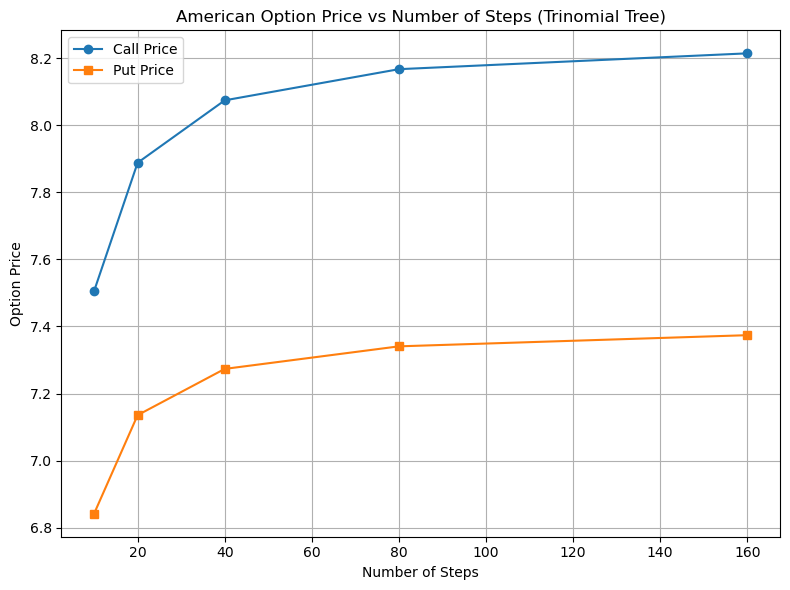

In [77]:
def plot_price_vs_steps(n_steps_list, prices_call, prices_put):
    plt.figure(figsize=(8, 6))
    plt.plot(n_steps_list, prices_call, 'o-', label='Call Price')
    plt.plot(n_steps_list, prices_put, 's-', label='Put Price')
    plt.xlabel('Number of Steps')
    plt.ylabel('Option Price')
    plt.title('American Option Price vs Number of Steps (Trinomial Tree)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run the plot
plot_price_vs_steps(n_steps_list, prices_call, prices_put)


In [78]:
def convergence_plot_trinomial(option_type='put', S0=100, K=100, T=1.0, r=0.03, sigma=0.2,
                               step_range=range(5, 500, 5), reference_price=None):
    """
    Plots American option prices using Trinomial Tree for increasing n_steps.
    Optionally compares to a reference price (e.g., European price).
    """
    prices = []
    steps = []

    for n in step_range:
        option = AmericanOptionTrinomial(S0, K, T, r, sigma, n_steps=n, option_type=option_type)
        price = option.price()
        prices.append(price)
        steps.append(n)

    plt.figure(figsize=(10, 6))
    plt.plot(steps, prices, marker='o', label=f'American {option_type.title()} Price')

    if reference_price is not None:
        plt.axhline(reference_price, color='r', linestyle='--',
                    label=f'Reference ({option_type.title()} European Price)')

    plt.xlabel('Number of Time Steps (n_steps)')
    plt.ylabel('Option Price')
    plt.title(f'Convergence of Trinomial American {option_type.title()} Option Price')
    plt.legend()
    plt.grid(True)
    plt.show()


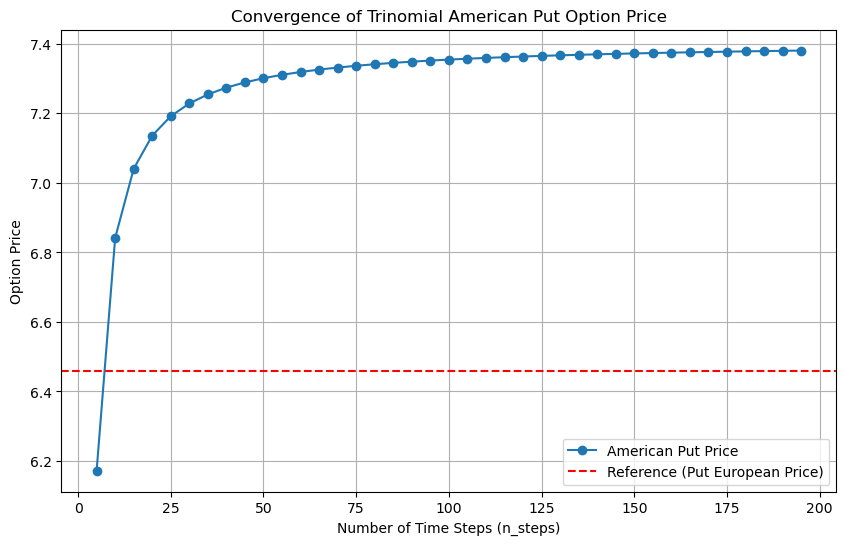

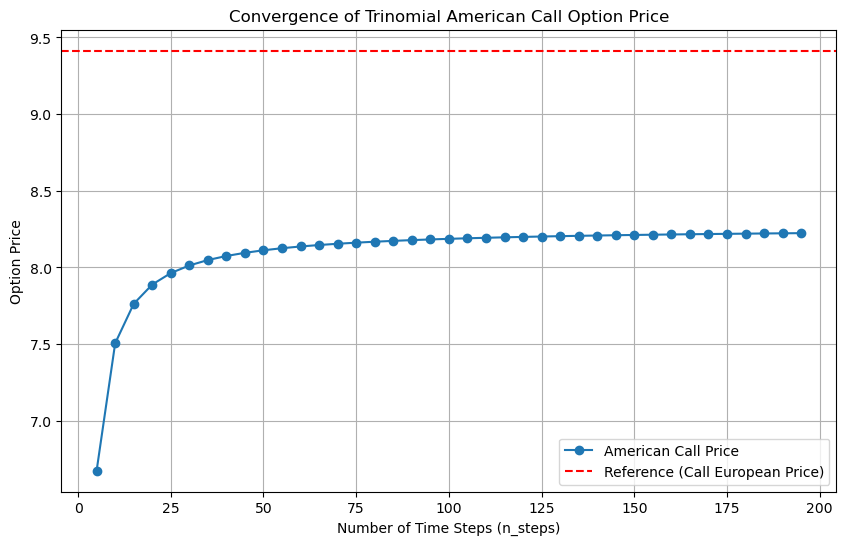

In [79]:
# European reference price for comparison
bs_price_put = black_scholes_price(S0, K, T, r, sigma, option_type='put')
bs_price_call = black_scholes_price(S0, K, T, r, sigma, option_type='call')

# Plot for put
convergence_plot_trinomial('put', S0, K, T, r, sigma, step_range=range(5, 200, 5), reference_price=bs_price_put)

# Plot for call
convergence_plot_trinomial('call', S0, K, T, r, sigma, step_range=range(5, 200, 5), reference_price=bs_price_call)


Estimate Convergence Rate

In [74]:
def estimate_convergence_rate(n_steps, prices):
    errors = np.abs(prices[:-1] - prices[-1])
    log_fit = np.polyfit(np.log(n_steps[:-1]), np.log(errors), 1)
    return log_fit[0], errors

rate_call, errors_call = estimate_convergence_rate(np.array(n_steps_list), prices_call)
rate_put, errors_put = estimate_convergence_rate(np.array(n_steps_list), prices_put)

print(f"Estimated convergence rate (Call): O(1/n^{abs(rate_call):.2f})")
print(f"Estimated convergence rate (Put):  O(1/n^{abs(rate_put):.2f})")


Estimated convergence rate (Call): O(1/n^1.29)
Estimated convergence rate (Put):  O(1/n^1.32)


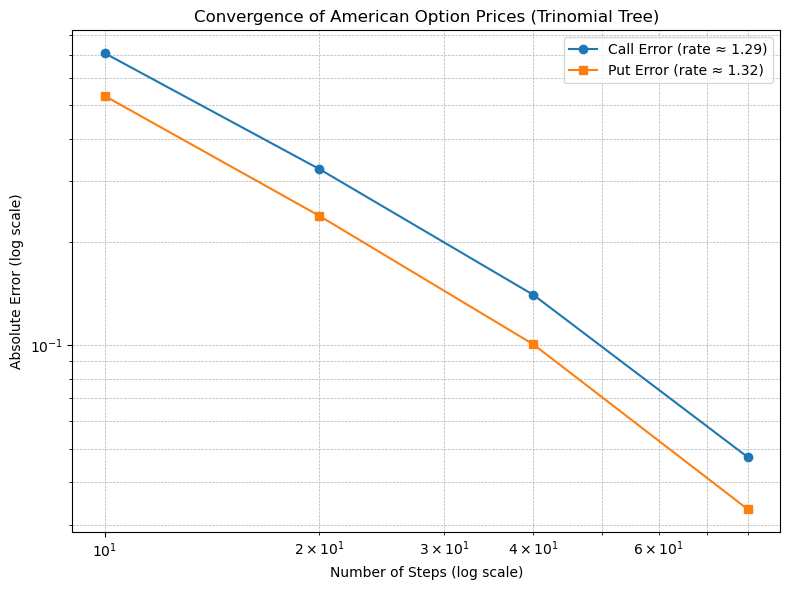

In [80]:
def plot_convergence_loglog(n_steps_list, errors_call, errors_put):
    plt.figure(figsize=(8, 6))
    plt.loglog(n_steps_list[:-1], errors_call, 'o-', label=f'Call Error (rate ≈ {abs(rate_call):.2f})')
    plt.loglog(n_steps_list[:-1], errors_put, 's-', label=f'Put Error (rate ≈ {abs(rate_put):.2f})')
    plt.xlabel('Number of Steps (log scale)')
    plt.ylabel('Absolute Error (log scale)')
    plt.title('Convergence of American Option Prices (Trinomial Tree)')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the plot function
plot_convergence_loglog(n_steps_list, errors_call, errors_put)


Visualize Early Exercise Region

In [81]:
def get_early_exercise_map(option_type='put', S0=100, K=100, T=1.0, r=0.05, sigma=0.2, n_steps=100):
    """
    Returns a boolean matrix showing early exercise decisions in the trinomial tree.
    True means early exercise is optimal at that node.
    """
    model = AmericanOptionTrinomial(S0, K, T, r, sigma, n_steps=n_steps, option_type=option_type)
    size = 2 * n_steps + 1
    dt = T / n_steps

    V = np.zeros((size, n_steps + 1))
    exercise_map = np.zeros_like(V, dtype=bool)

    # Terminal payoff at maturity
    for i in range(size):
        j = i - n_steps
        ST = S0 * model.u ** j
        V[i, n_steps] = model.payoff(ST)

    # Backward induction
    for t in reversed(range(n_steps)):
        for i in range(t + 1, 2 * n_steps - t):
            j = i - n_steps
            S = S0 * model.u ** j
            continuation = model.discount * (
                model.pu * V[i - 1, t + 1] +
                model.pm * V[i, t + 1] +
                model.pd * V[i + 1, t + 1]
            )
            exercise = model.payoff(S)
            V[i, t] = max(continuation, exercise)
            exercise_map[i, t] = exercise > continuation

    return exercise_map



In [82]:
def plot_early_exercise_map(exercise_map, option_type='put'):
    plt.figure(figsize=(10, 6))
    plt.imshow(exercise_map, origin='lower', cmap='coolwarm', aspect='auto')
    plt.colorbar(label='Early Exercise (1=True, 0=False)')
    plt.xlabel('Time Step')
    plt.ylabel('Tree Node Index')
    plt.title(f'Early Exercise Region for American {option_type.title()} Option (Trinomial Tree)')
    plt.tight_layout()
    plt.show()


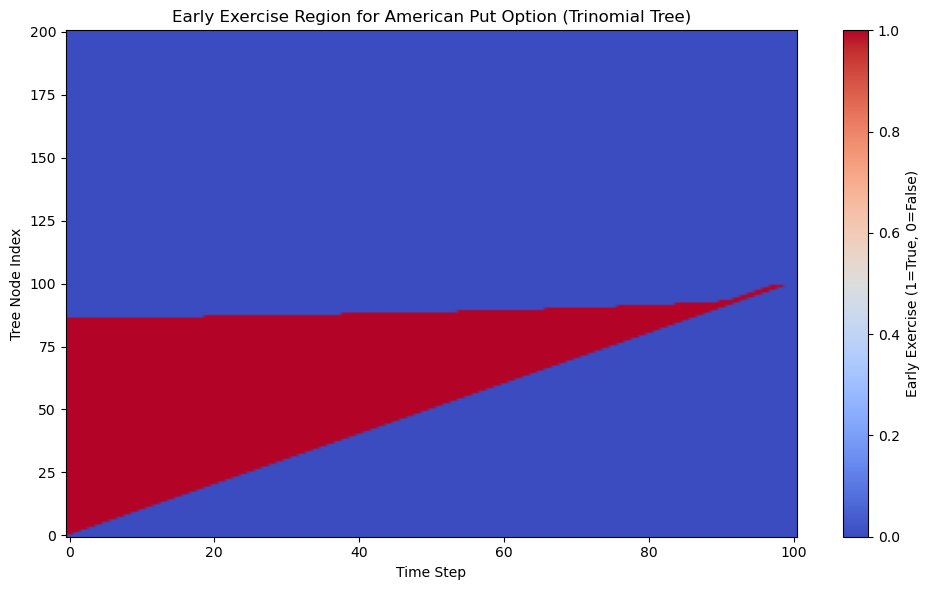

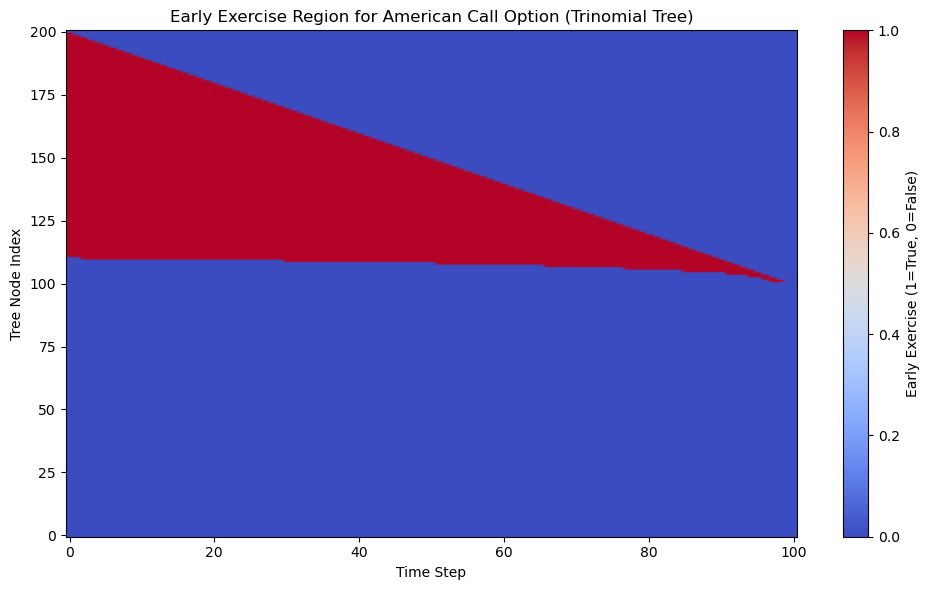

In [83]:
# For American Put Option
exercise_map_put = get_early_exercise_map('put', n_steps=100)
plot_early_exercise_map(exercise_map_put, 'put')

# For American Call Option
exercise_map_call = get_early_exercise_map('call', n_steps=100)
plot_early_exercise_map(exercise_map_call, 'call')


In [86]:
def plot_early_exercise_dots(exercise_map, option_type='put'):
    n_steps = exercise_map.shape[1] - 1
    x_vals = []
    y_vals = []

    for t in range(n_steps + 1):
        for i in range(2 * n_steps + 1):
            if exercise_map[i, t]:
                x_vals.append(t)
                y_vals.append(i - n_steps)  # node index centered at 0

    plt.figure(figsize=(10, 6))
    plt.scatter(x_vals, y_vals, s=10, color='red', label='Early Exercise')
    plt.xlabel('Time Step')
    plt.ylabel('Node Index (j)')
    plt.title(f'Early Exercise Region - American {option_type.title()} Option (Trinomial Tree)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


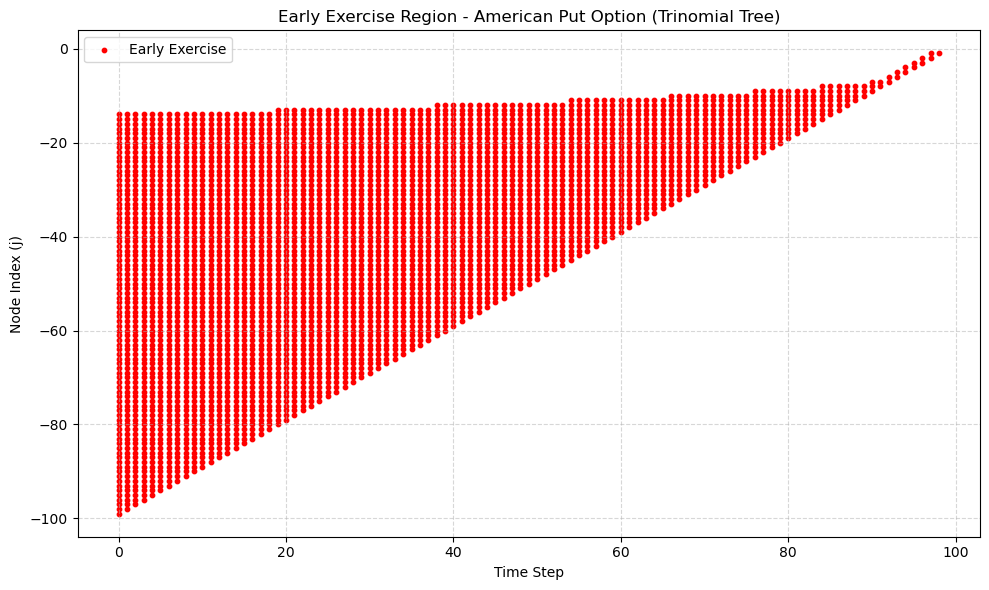

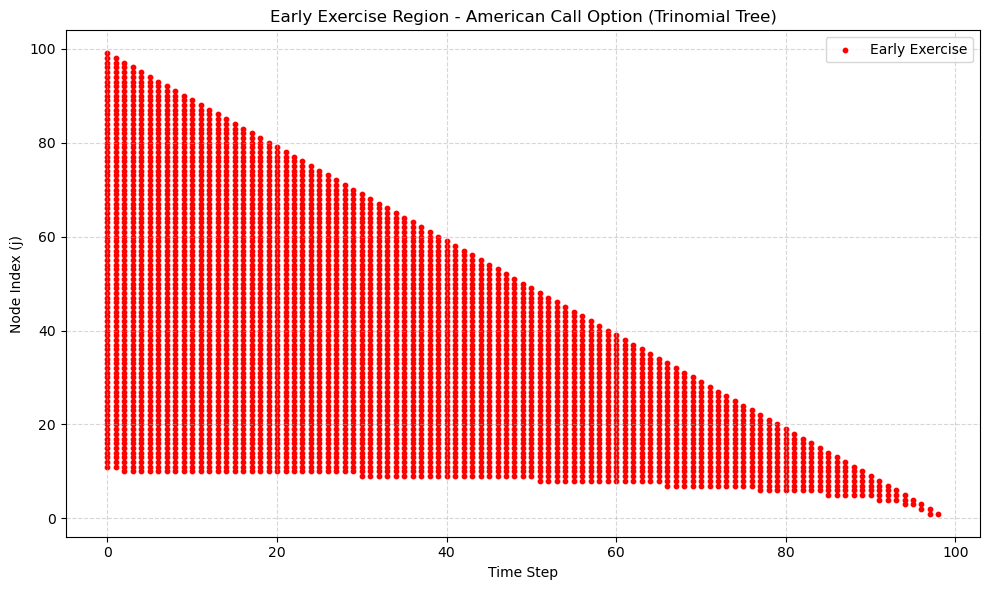

In [87]:
# Get early exercise region
map_put = get_early_exercise_map('put', n_steps=100)
plot_early_exercise_dots(map_put, 'put')

map_call = get_early_exercise_map('call', n_steps=100)
plot_early_exercise_dots(map_call, 'call')


### 3. American Option Pricing using Least-Squares Monte Carlo (LSM)

The Least-Squares Monte Carlo (LSM) method by Longstaff and Schwartz (2001) is a simulation-based technique to price American options by estimating the continuation value using regression.



####  Simulate Stock Price Paths using GBM
We begin by simulating multiple stock price paths under the risk-neutral measure using Geometric Brownian Motion (GBM). These paths will be used to evaluate the option's continuation and exercise values in the LSM framework.


In [90]:
def simulate_gbm_paths(S0, r, sigma, T, n_steps, n_paths):
    """
    Simulates GBM stock price paths for use in Monte Carlo.
    
    Returns: (n_paths x (n_steps+1)) matrix of stock prices
    """
    dt = T / n_steps
    Z = np.random.normal(size=(n_paths, n_steps))
    S = np.zeros((n_paths, n_steps + 1))
    S[:, 0] = S0

    for t in range(1, n_steps + 1):
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t-1])
    
    return S


#### Define Payoff Structure

We implement a general payoff function to handle both American put and call options. At each time step, we'll compare the immediate payoff to the estimated continuation value to determine the optimal decision.


In [91]:
def payoff(S, K, option_type='put'):
    if option_type == 'put':
        return np.maximum(K - S, 0)
    elif option_type == 'call':
        return np.maximum(S - K, 0)
    else:
        raise ValueError("option_type must be 'call' or 'put'")


#### Implement Least-Squares Monte Carlo (LSM) Pricing

We now use backward induction to compute the optimal stopping strategy for American options. At each time step, we perform regression using in-the-money paths to estimate the continuation value. The regression basis uses polynomials ( simple monomials) of the stock price.


In [102]:
def LSM_price(S0, K, T, r, sigma, n_steps=100, n_paths=10000, option_type='put', degree=2):
    dt = T / n_steps
    discount = np.exp(-r * dt)
    
    # Simulate stock price paths
    paths = simulate_gbm_paths(S0, r, sigma, T, n_steps, n_paths)
    payoffs = payoff(paths, K, option_type)
    
    # Initialize cashflows with final payoffs
    CF = payoffs[:, -1]

    for t in range(n_steps - 1, 0, -1):
        # In-the-money paths only
        itm = payoffs[:, t] > 0
        X = paths[itm, t]
        Y = CF[itm] * discount

        # Regression to estimate continuation value
        if len(X) > 0:
            A = np.vander(X, N=degree+1, increasing=True)  # Polynomial basis
            coeffs = np.linalg.lstsq(A, Y, rcond=None)[0]
            continuation_val = A @ coeffs

            # Decide whether to exercise or continue
            exercise_val = payoffs[itm, t]
            exercise = exercise_val > continuation_val

            # Update cashflows
            CF[itm] = np.where(exercise, exercise_val, CF[itm] * discount)
        else:
            CF *= discount

    return np.mean(CF * np.exp(-r * dt))  # Discount back to t=0


In [103]:
S0 = 100
K = 100
T = 1.0
r = 0.03
sigma = 0.2

price_put = LSM_price(S0, K, T, r, sigma, option_type='put')
price_call = LSM_price(S0, K, T, r, sigma, option_type='call')

print(f"American Put Option Price (LSM): {price_put:.4f}")
print(f"American Call Option Price (LSM): {price_call:.4f}")


American Put Option Price (LSM): 6.8298
American Call Option Price (LSM): 9.1695


#### Regression with Laguerre Polynomials

In [104]:
def LSM_price_lg(S0, K, T, r, sigma, n_steps=100, n_paths=10000, option_type='put', degree=2):
    dt = T / n_steps
    discount = np.exp(-r * dt)
    
    # Simulate stock price paths
    paths = simulate_gbm_paths(S0, r, sigma, T, n_steps, n_paths)
    payoffs = payoff(paths, K, option_type)
    
    # Initialize cashflows with final payoffs
    CF = payoffs[:, -1]

    for t in range(n_steps - 1, 0, -1):
        # In-the-money paths only
        itm = payoffs[:, t] > 0
        X = paths[itm, t]
        Y = CF[itm] * discount

        # Regression to estimate continuation value
        if len(X) > 0:
            # Laguerre polynomial regression
            A = lagval(X, [1.0] + [0.0]*degree)  # Evaluate Laguerre basis at X
            B = np.vstack([lagval(X, [0.0]*i + [1.0] + [0.0]*(degree - i)) for i in range(degree+1)]).T
            coeffs = np.linalg.lstsq(B, Y, rcond=None)[0]
            continuation_val = B @ coeffs


            # Decide whether to exercise or continue
            exercise_val = payoffs[itm, t]
            exercise = exercise_val > continuation_val

            # Update cashflows
            CF[itm] = np.where(exercise, exercise_val, CF[itm] * discount)
        else:
            CF *= discount

    return np.mean(CF * np.exp(-r * dt))  # Discount back to t=0


In [105]:
S0 = 100
K = 100
T = 1.0
r = 0.03
sigma = 0.2

price_put_lg = LSM_price_lg(S0, K, T, r, sigma, option_type='put')
price_call_lg = LSM_price_lg(S0, K, T, r, sigma, option_type='call')

print(f"American Put Option Price (LSM:Laguerre): {price_put_lg:.4f}")
print(f"American Call Option Price (LSM:Laguerre): {price_call_lg:.4f}")


American Put Option Price (LSM:Laguerre): 6.8130
American Call Option Price (LSM:Laguerre): 9.8519


#### Comparison

In [113]:


print(f"{'Method':<30} {'      Call Price     ':>12} {'Put Price     ':>12}")
print("-" * 85)
print(f"{'Black-Scholes (Europian)            ':<30} {bs_call:12.4f} {bs_put:12.4f}")
print(f"{'CRR Binomial (American)             ':<30} {crr_call:12.4f} {crr_put:12.4f}")
print(f"{'Trinomial Tree (American)           ':<30} {tri_call:12.4f} {tri_put:12.4f}")
print(f"{'LSM Monte Carlo(Poly reg) (American)':<20} {price_call:12.4f} {price_put:12.4f}")
print(f"{'LSM Monte Carlo (Laguerre)(American)':<20} {price_call_lg:12.4f} {price_put_lg:12.4f}")


Method                               Call Price      Put Price     
-------------------------------------------------------------------------------------
Black-Scholes (Europian)                   9.4134       6.4580
CRR Binomial (American)                    9.4094       6.7411
Trinomial Tree (American)                  8.2481       7.3967
LSM Monte Carlo(Poly reg) (American)       9.1695       6.8298
LSM Monte Carlo (Laguerre)(American)       9.8519       6.8130


We compared American option prices computed via CRR Binomial Tree, Trinomial Tree, and Least-Squares Monte Carlo (LSM) with both polynomial and Laguerre basis functions, against the European prices from Black-Scholes. All methods produce reasonable results, with American put prices consistently higher than European due to early exercise premium. Call prices remain close to European values, with LSM (Laguerre) slightly overestimating due to basis sensitivity.

#### Convergence analysis for the LSM method

Plot Option Price vs Number of Paths

In [118]:
def lsm_convergence_plot_dual(S0=100, K=100, T=1.0, r=0.03, sigma=0.2,
                              option_type='put', degree=2, method='poly',
                              path_range=range(1000, 25001, 1000), n_steps=500):
    prices = []

    for n_paths in path_range:
        if method == 'poly':
            price = LSM_price(S0, K, T, r, sigma, n_steps=n_steps, n_paths=n_paths,
                              option_type=option_type, degree=degree)
        elif method == 'laguerre':
            price = LSM_price_lg(S0, K, T, r, sigma, n_steps=n_steps, n_paths=n_paths,
                                 option_type=option_type, degree=degree)
        else:
            raise ValueError("Method must be 'poly' or 'laguerre'")
        
        prices.append(price)

    plt.figure(figsize=(10, 6))
    plt.plot(path_range, prices, marker='o', label=f'{option_type.title()} Price')
    plt.xlabel("Number of Monte Carlo Paths")
    plt.ylabel("Option Price")
    title_label = "Polynomial" if method == 'poly' else "Laguerre"
    plt.title(f"LSM {option_type.title()} Price vs Paths ({title_label} Regression)")
    plt.grid(True)
    plt.legend()
    plt.show()


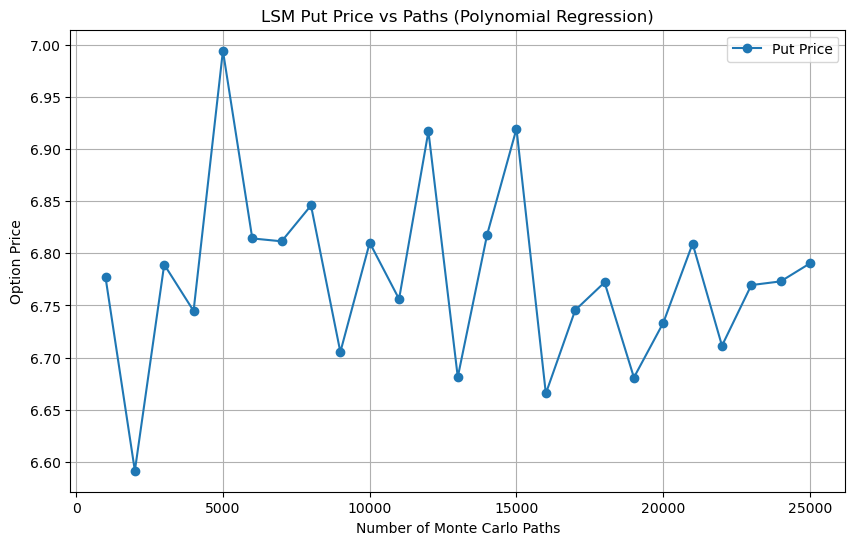

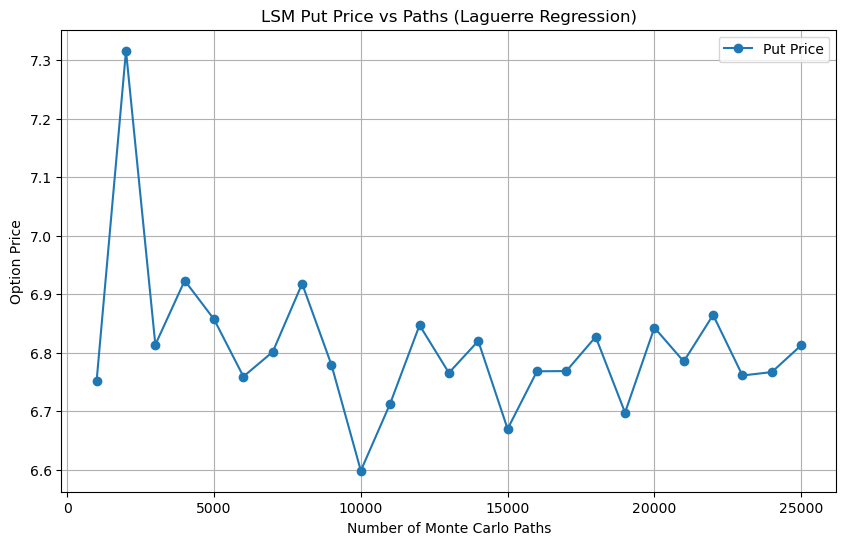

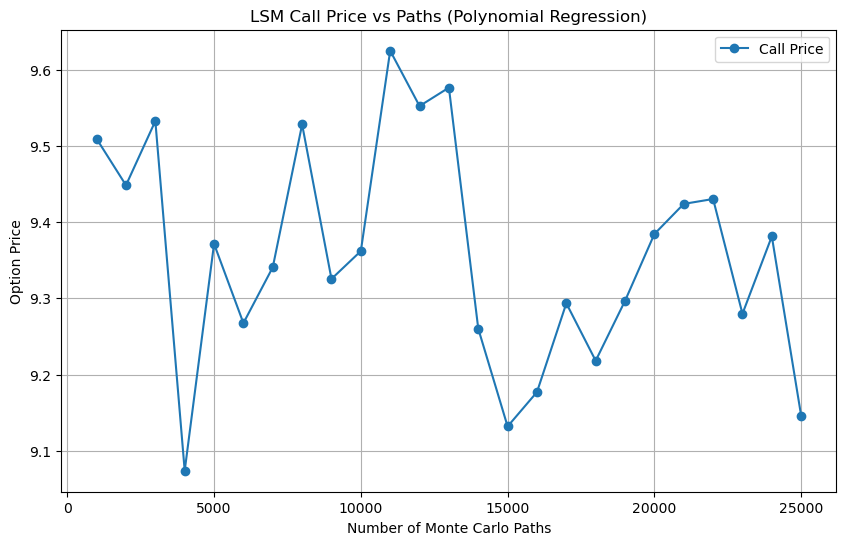

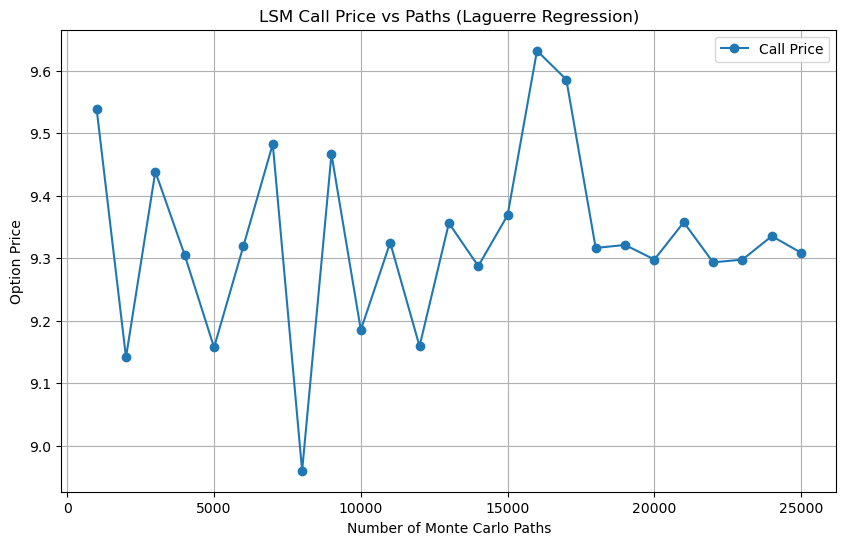

In [119]:
# Convergence for American Put with Polynomial
lsm_convergence_plot_dual(option_type='put', method='poly')

# Convergence for American Put with Laguerre
lsm_convergence_plot_dual(option_type='put', method='laguerre')

# Convergence for American Call with Poly
lsm_convergence_plot_dual(option_type='call', method='poly')

# Convergence for American Call with Laguerre
lsm_convergence_plot_dual(option_type='call', method='laguerre')


#### Estimate the convergence rate of LSM 

In [120]:
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

def estimate_lsm_convergence_rate(S0=100, K=100, T=1.0, r=0.03, sigma=0.2,
                                  option_type='put', degree=2, method='poly',
                                  path_range=range(1000, 25001, 1000),
                                  n_steps=500, reference_price=None):
    errors = []
    steps = []

    for n_paths in path_range:
        if method == 'poly':
            price = LSM_price(S0, K, T, r, sigma, n_steps=n_steps, n_paths=n_paths,
                              option_type=option_type, degree=degree)
        elif method == 'laguerre':
            price = LSM_price_lg(S0, K, T, r, sigma, n_steps=n_steps, n_paths=n_paths,
                                 option_type=option_type, degree=degree)
        else:
            raise ValueError("Method must be 'poly' or 'laguerre'")
        
        error = abs(price - reference_price)
        errors.append(error)
        steps.append(n_paths)

    # Log-log regression
    log_n = np.log(steps)
    log_error = np.log(errors)
    slope, intercept, _, _, _ = linregress(log_n, log_error)
    rate = -slope

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(log_n, log_error, 'o-', label=f'Log(Error) vs Log(Paths)')
    plt.plot(log_n, intercept + slope * log_n, '--', label=f'Fit: slope = {slope:.2f}')
    plt.xlabel('log(Number of Paths)')
    plt.ylabel('log(Error)')
    method_str = "Polynomial" if method == 'poly' else "Laguerre"
    plt.title(f'LSM ({method_str}) {option_type.title()} Convergence Rate')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Estimated convergence rate ({method_str} - {option_type.title()}): O(1/n^{rate:.2f})")
    return rate


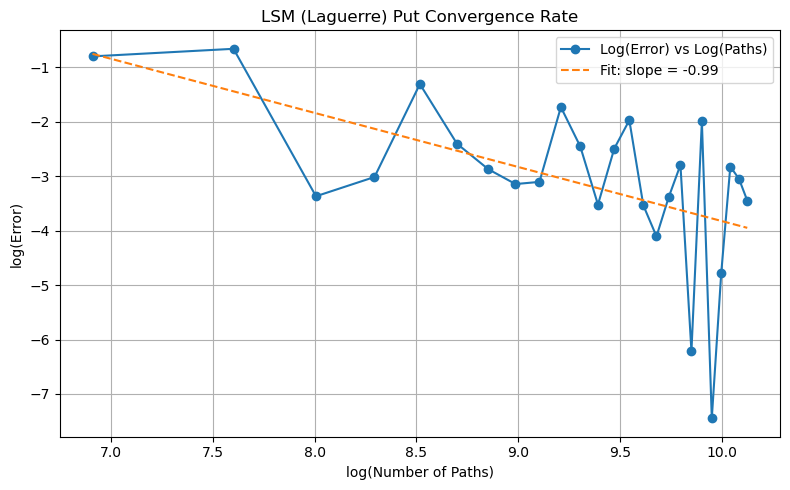

Estimated convergence rate (Laguerre - Put): O(1/n^0.99)


np.float64(0.9918376520564774)

In [121]:
estimate_lsm_convergence_rate(option_type='put', method='laguerre', reference_price=crr_put)


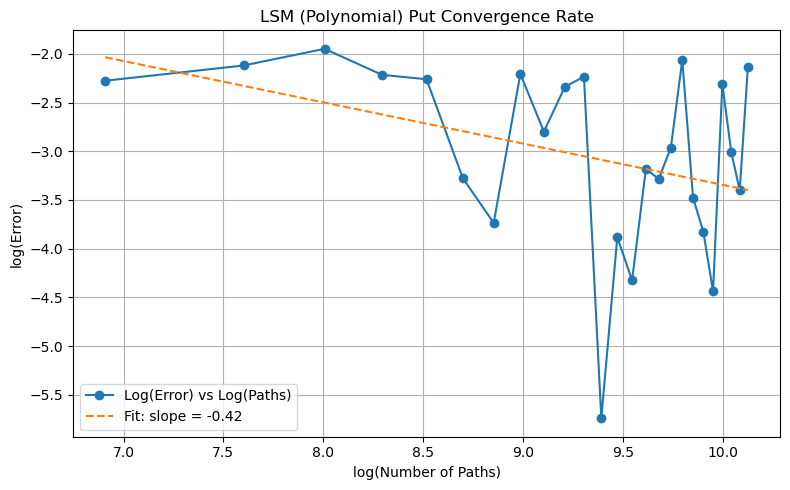

Estimated convergence rate (Polynomial - Put): O(1/n^0.42)


np.float64(0.42385432585977967)

In [122]:
estimate_lsm_convergence_rate(option_type='put', method='poly', reference_price=crr_put)


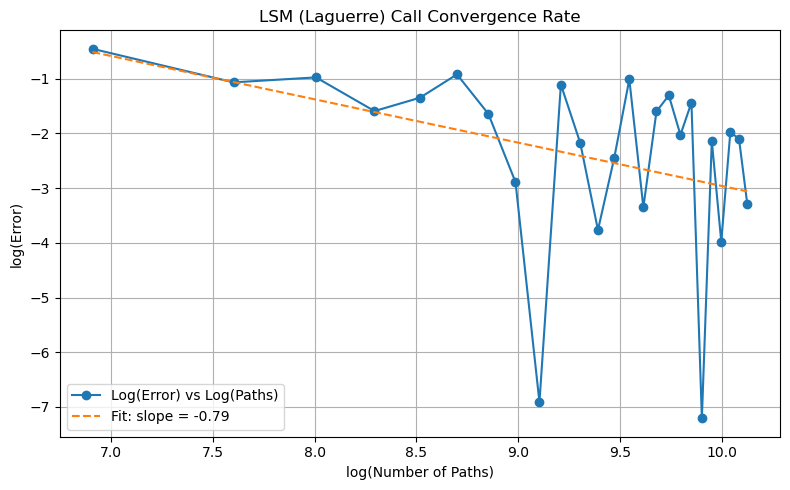

Estimated convergence rate (Laguerre - Call): O(1/n^0.79)


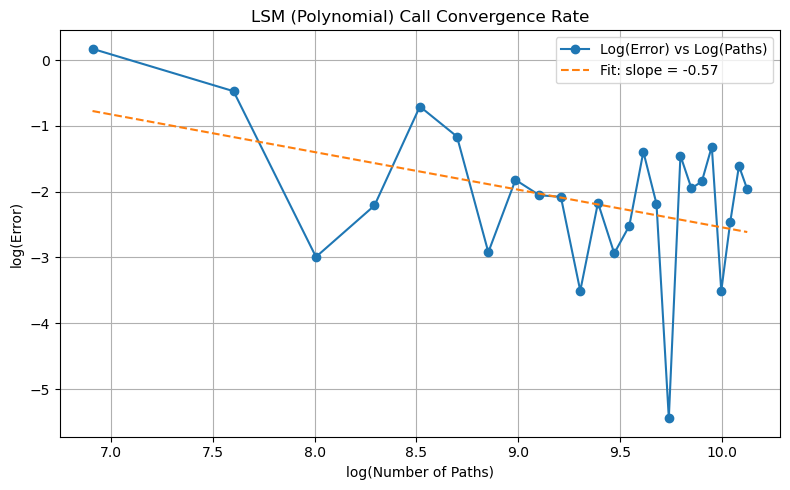

Estimated convergence rate (Polynomial - Call): O(1/n^0.57)


np.float64(0.5715486968780307)

In [123]:
estimate_lsm_convergence_rate(option_type='call', method='laguerre', reference_price=crr_call)
estimate_lsm_convergence_rate(option_type='call', method='poly', reference_price=crr_call)


The convergence analysis shows that the Laguerre basis leads to faster and more stable convergence in LSM pricing compared to the polynomial basis. Put options converge more reliably than call options, and Laguerre consistently outperforms polynomial regression in terms of convergence rate.



#### Visualizing Early Exercise (LSM)

In [127]:
def LSM_price_lg_exercise_map(S0, K, T, r, sigma, n_steps=100, n_paths=10000,
                              option_type='put', degree=2):
    dt = T / n_steps
    discount = np.exp(-r * dt)

    # Simulate paths
    Z = np.random.normal(size=(n_paths, n_steps))
    S = np.zeros_like(Z)
    S[:, 0] = S0

    for t in range(1, n_steps):
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z[:, t])

    # Initialize cashflows and exercise tracker
    if option_type == 'put':
        payoff = np.maximum(K - S[:, -1], 0)
    else:
        payoff = np.maximum(S[:, -1] - K, 0)

    exercise_map = np.zeros_like(S)

    for t in range(n_steps - 2, 0, -1):
        itm = (np.maximum(K - S[:, t], 0) if option_type == 'put'
               else np.maximum(S[:, t] - K, 0)) > 0
        X = S[itm, t]
        Y = payoff[itm] * discount

        if len(X) == 0:
            continue

        # Laguerre regression
        B = np.vstack([lagval(X, [0]*i + [1] + [0]*(degree - i)) for i in range(degree + 1)]).T
        coeffs = np.linalg.lstsq(B, Y, rcond=None)[0]
        continuation_val = B @ coeffs

        exercise_val = (np.maximum(K - X, 0) if option_type == 'put'
                        else np.maximum(X - K, 0))

        exercise_now = exercise_val > continuation_val
        idx = np.where(itm)[0][exercise_now]
        payoff[idx] = exercise_val[exercise_now]
        exercise_map[idx, t] = 1

    return exercise_map, S


In [128]:
def plot_exercise_map(exercise_map, stock_paths, option_type='put'):
    n_paths, n_steps = stock_paths.shape

    plt.figure(figsize=(10, 6))
    for i in range(n_paths):
        exercise_times = np.where(exercise_map[i] == 1)[0]
        if len(exercise_times) > 0:
            t = exercise_times[0]
            plt.plot(t, stock_paths[i, t], 'ro', markersize=3)

    plt.xlabel("Time Step")
    plt.ylabel("Stock Price")
    plt.title(f"Early Exercise Region (LSM - {option_type.title()})")
    plt.grid(True)
    plt.show()


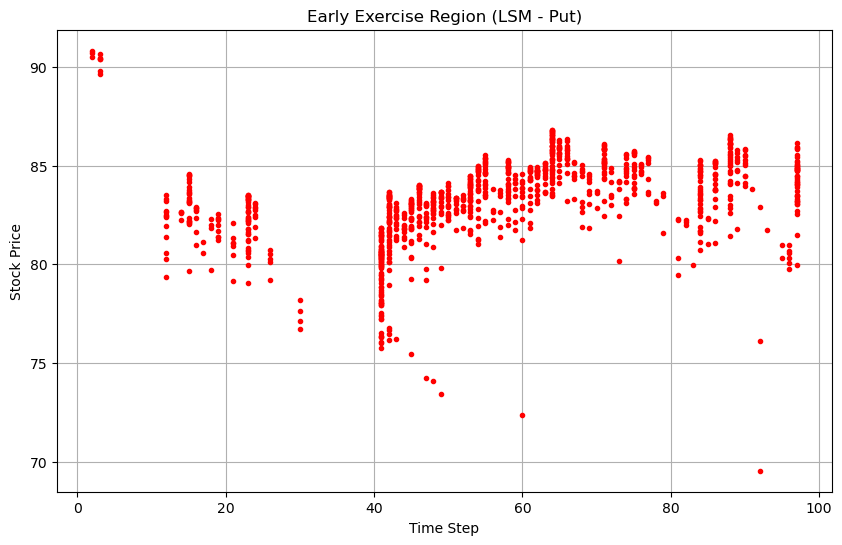

In [130]:
emap, S_paths = LSM_price_lg_exercise_map(S0=100, K=100, T=1.0, r=0.03, sigma=0.2,
                                          n_steps=100, n_paths=3000,
                                          option_type='put', degree=2)
plot_exercise_map(emap, S_paths, option_type='put')


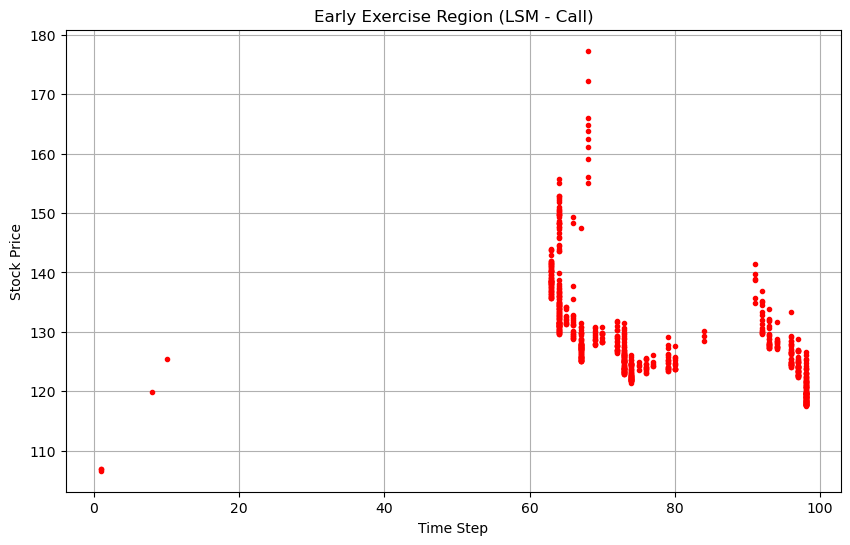

In [131]:
emap_c, S_paths_c = LSM_price_lg_exercise_map(S0=100, K=100, T=1.0, r=0.03, sigma=0.2,
                                          n_steps=100, n_paths=3000,
                                          option_type='call', degree=2)
plot_exercise_map(emap_c, S_paths_c, option_type='call')


The LSM method offers a highly flexible and intuitive framework for pricing American options, particularly when dealing with high-dimensional or path-dependent payoffs where traditional tree-based methods become computationally infeasible. By leveraging regression techniques to approximate continuation values, LSM efficiently handles early exercise decisions without requiring a full tree structure. Our analysis shows that LSM yields accurate and consistent prices and provides insight into early exercise behavior. The choice of basis functions significantly affects convergence, with Laguerre polynomials offering superior performance in our tests.

### 4. American Option Pricing Using Finite Difference Methods

In this module, we implement three finite difference schemes—Explicit, Implicit, and Crank-Nicolson—to price American options. These methods solve the Black-Scholes PDE with early exercise constraints by discretizing both the time and asset price dimensions.




#### A. Explicit Method

In [211]:
def american_option_explicit_coeff(S0, K, T, r, sigma, S_max=3*K, M=200, N=5000, option_type="put"):
    """
    American Option Pricing using Explicit Finite Difference Method.

    Parameters:
        S0         : Initial stock price
        K          : Strike price
        T          : Time to maturity (in years)
        r          : Annualized risk-free interest rate
        sigma      : Annualized volatility
        S_max      : Maximum stock price in grid
        M          : Number of spatial steps (stock prices)
        N          : Number of time steps
        option_type: 'put' or 'call'
    
    Returns:
        S : Stock price grid
        V0: Option values at t=0
    """
    dt = T / N
    dS = S_max / M
    S = np.linspace(0, S_max, M + 1)

    V = np.zeros((M + 1, N + 1))  # V[i, n] is the option value at node (i*dS, n*dt)

    # Terminal condition (payoff at maturity)
    if option_type == "put":
        V[:, -1] = np.maximum(K - S, 0)
    elif option_type == "call":
        V[:, -1] = np.maximum(S - K, 0)
    else:
        raise ValueError("option_type must be 'put' or 'call'")

    # Boundary conditions for all time levels
    if option_type == "put":
        V[0, :] = K * np.exp(-r * dt * np.arange(N + 1))  # S = 0 boundary
        V[-1, :] = 0                                      # S = S_max boundary
    else:
        V[0, :] = 0
        V[-1, :] = (S_max - K) * np.exp(-r * dt * np.arange(N + 1))

    # Backward induction in time
    for n in reversed(range(N)):
        for i in range(1, M):
            # Stock price at this node
            Si = i * dS

            # Coefficients from discretization of Black-Scholes PDE
            a = 0.5 * dt * (sigma**2 * i**2 - r * i)
            b = 1 - dt * (sigma**2 * i**2 + r)
            c = 0.5 * dt * (sigma**2 * i**2 + r * i)

            # Explicit update formula
            V[i, n] = a * V[i - 1, n + 1] + b * V[i, n + 1] + c * V[i + 1, n + 1]

            # Early exercise constraint (American-style)
            if option_type == "put":
                V[i, n] = max(V[i, n], K - Si)
            else:
                V[i, n] = max(V[i, n], Si - K)

    return S, V[:, 0]


In [212]:
S, V0 = american_option_explicit_coeff(S0=100, K=100, T=1, r=0.03, sigma=0.2, option_type="put")
price = interp1d(S, V0)(100)
print(f"American Put Price (Explicit FDM): {price:.4f}")


American Put Price (Explicit FDM): 6.7458


Comapre

In [213]:
print(f"{'Method':<30} {'          Put Price     ':>12}")
print("-" * 65)
print(f"{'Black-Scholes (Europian)            ':<30}  {bs_put:12.4f}")
print(f"{'CRR Binomial (American)             ':<30}  {crr_put:12.4f}")
print(f"{'Trinomial Tree (American)           ':<30}  {tri_put:12.4f}")
print(f"{'LSM Monte Carlo(Poly reg) (American)':<20}  {price_put:12.4f}")
print(f"{'LSM Monte Carlo (Laguerre)(American)':<20}  {price_put_lg:12.4f}")
print(f"{'FD Explicit (American)              ':<20}  {price:12.4f}")


Method                                   Put Price     
-----------------------------------------------------------------
Black-Scholes (Europian)                    6.4580
CRR Binomial (American)                     6.7411
Trinomial Tree (American)                   7.3967
LSM Monte Carlo(Poly reg) (American)        6.8298
LSM Monte Carlo (Laguerre)(American)        6.8130
FD Explicit (American)                      6.7458


Explicit FDM produced similar and accurate results around 6.75, consistent with CRR Binomial American put option peice.

#### Convergence Analysis

 Option Price vs. Number of Time Steps

In [224]:
def convergence_plot_explicit_fd(S0=100, K=100, T=1.0, r=0.03, sigma=0.2,
                                 M=200, step_range=range(500, 5000, 500),
                                 reference_price=6.7411): 
    prices = []
    steps = []

    for N in step_range:
        S, V0 = american_option_explicit_coeff(S0, K, T, r, sigma, M=200, N=5000, option_type="put")
        price = interp1d(S, V0)(S0)
        prices.append(price)
        steps.append(N)

    plt.figure(figsize=(10, 6))
    plt.plot(steps, prices, marker='o', label='Explicit FDM Price')
    plt.axhline(reference_price, color='r', linestyle='--', label='CRR Binomial Price')
    plt.xlabel("Number of Time Steps (N)")
    plt.ylabel("Option Price")
    plt.title("Convergence of American Put (Explicit FDM)")
    plt.grid(True)
    plt.legend()
    plt.show()


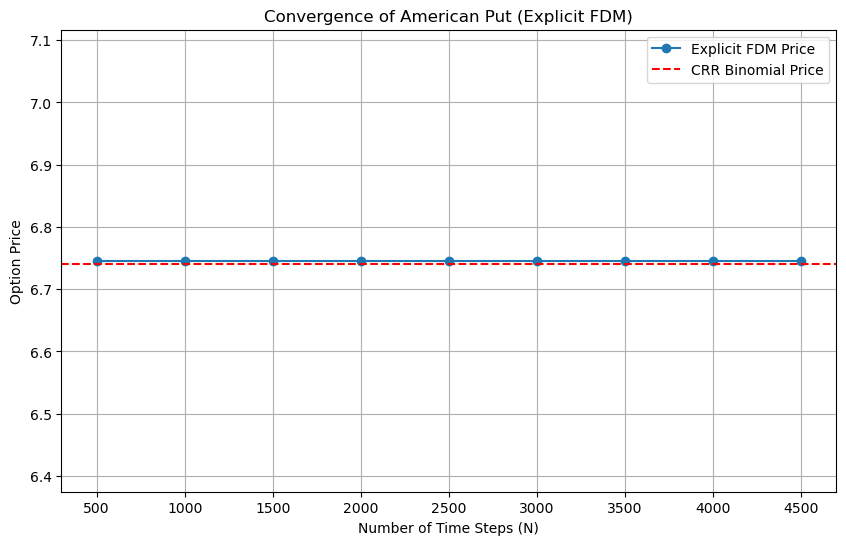

In [225]:
convergence_plot_explicit_fd()


#### Estimate Convergence Rate


In [240]:
def estimate_convergence_rate_fd(S0=100, K=100, T=1.0, r=0.03, sigma=0.2,
                                 M=200, step_range=range(500, 5000, 500),
                                 reference_price=6.7):
    errors = []
    steps = []

    for N in step_range:
        S, V0 = american_option_explicit_coeff(S0, K, T, r, sigma, M=M, N=N, option_type="put")
        price = interp1d(S, V0)(S0)
        error = abs(price - reference_price)
        errors.append(error)
        steps.append(N)

    # Linear regression on log-log
    log_N = np.log(steps).reshape(-1, 1)
    log_err = np.log(errors)
    reg = LinearRegression().fit(log_N, log_err)
    rate = -reg.coef_[0]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(steps, errors, marker='o')
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Time Steps (log scale)")
    plt.ylabel("Absolute Error (log scale)")
    plt.title(f"Convergence Rate: O(1/N^{rate:.2f})")
    plt.grid(True)
    plt.show()

    return rate


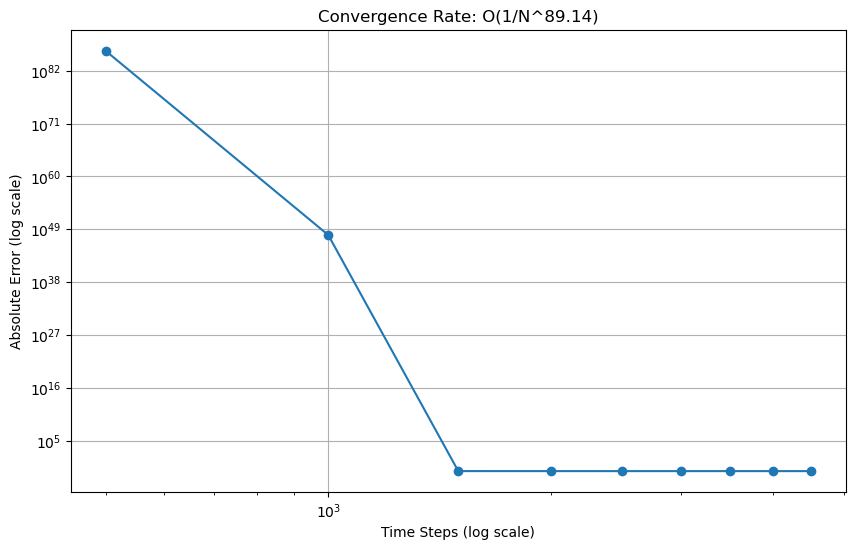

Estimated convergence rate: O(1/N^89.14)


In [241]:
rate = estimate_convergence_rate_fd()
print(f"Estimated convergence rate: O(1/N^{rate:.2f})")


The convergence is way too faster than the other methods!

### B. Implicit FDM for American Put Options

In [267]:
def american_put_implicit_fdm(S0=100, K=100, T=1.0, r=0.03, sigma=0.2, S_max=200, M=200, N=200):
    dS = S_max / M
    dt = T / N
    S = np.linspace(0, S_max, M + 1)
    V = np.maximum(K - S, 0)  # Initial payoff

    i = np.arange(1, M)
    alpha = 0.5 * dt * (sigma**2 * i**2 - r * i)
    beta  = 1 + dt * (sigma**2 * i**2 + r)
    gamma = 0.5 * dt * (sigma**2 * i**2 + r * i)

    # Banded matrix setup
    ab = np.zeros((3, M - 1))
    ab[0, 1:] = -gamma[:-1]
    ab[1, :]  = beta
    ab[2, :-1] = -alpha[1:]

    for _ in range(N):
        rhs = V[1:M].copy()
        rhs[0] += alpha[0] * K  # Boundary condition at S=0
        V[1:M] = solve_banded((1, 1), ab, rhs)
        V[1:M] = np.maximum(V[1:M], K - S[1:M])  # Early exercise condition

    # Interpolation to get value at S0
    return np.interp(S0, S, V)


In [268]:
price_impl = american_put_implicit_fdm()
print(f" American Put Option Price using Implicit FDM: {price_impl:.4f}")


 American Put Option Price using Implicit FDM: 6.7298


American Put option price with Implicit Finite Difference method consistent with what we have with Binomial tree model. 

#### Convergence Analysis 

In [270]:
# Reference CRR price
crr_price = 6.7411

# Explicit FDM
def american_put_explicit_fdm(S0, K, T, r, sigma, S_max=200, M=200, N=200):
    dS = S_max / M
    dt = T / N
    S = np.linspace(0, S_max, M + 1)
    V = np.maximum(K - S, 0)

    for n in reversed(range(N)):
        for i in range(1, M):
            delta = (V[i + 1] - V[i - 1]) / (2 * dS)
            gamma = (V[i + 1] - 2 * V[i] + V[i - 1]) / (dS ** 2)
            theta = -0.5 * sigma ** 2 * S[i] ** 2 * gamma - r * S[i] * delta + r * V[i]
            V[i] = V[i] - dt * theta
        V[0] = K
        V[M] = 0
        V = np.maximum(V, K - S)

    return np.interp(S0, S, V)

# Implicit FDM
def american_put_implicit_fdm_clean(S0=100, K=100, T=1.0, r=0.03, sigma=0.2, S_max=200, M=200, N=200):
    dS = S_max / M
    dt = T / N
    S = np.linspace(0, S_max, M + 1)
    V = np.maximum(K - S, 0)

    i = np.arange(1, M)
    alpha = 0.5 * dt * (sigma**2 * i**2 - r * i)
    beta  = 1 + dt * (sigma**2 * i**2 + r)
    gamma = 0.5 * dt * (sigma**2 * i**2 + r * i)

    ab = np.zeros((3, M - 1))
    ab[0, 1:] = -gamma[:-1]
    ab[1, :]  = beta
    ab[2, :-1] = -alpha[1:]

    for _ in range(N):
        rhs = V[1:M].copy()
        rhs[0] += alpha[0] * K
        V[1:M] = solve_banded((1, 1), ab, rhs)
        V[1:M] = np.maximum(V[1:M], K - S[1:M])

    return np.interp(S0, S, V)


In [271]:
# Convergence data collector
def convergence_analysis_fdm(S0=100, K=100, T=1.0, r=0.03, sigma=0.2, S_max=200,
                              method='explicit', step_range=range(100, 1001, 100), ref_price=None):
    prices = []
    errors = []
    Ns = []

    for N in step_range:
        if method == 'explicit':
            price = american_put_explicit_fdm(S0, K, T, r, sigma, S_max, M=N, N=N)
        elif method == 'implicit':
            price = american_put_implicit_fdm_clean(S0, K, T, r, sigma, S_max, M=N, N=N)
        else:
            raise ValueError("Invalid method type")
        error = abs(price - ref_price) if ref_price else 0
        prices.append(price)
        errors.append(error)
        Ns.append(N)

    return Ns, prices, errors

# Plot prices vs steps
def plot_option_prices_vs_N(Ns_exp, prices_exp, Ns_imp, prices_imp):
    plt.figure(figsize=(10, 6))
    plt.plot(Ns_exp, prices_exp, 'o-', label='Explicit FDM')
    plt.plot(Ns_imp, prices_imp, 's-', label='Implicit FDM')
    plt.axhline(y=crr_price, color='r', linestyle='--', label='CRR Reference Price')
    plt.xlabel('Number of Time Steps (N)')
    plt.ylabel('Option Price')
    plt.title('Convergence of American Put Option Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot convergence rate
def plot_convergence_rate(Ns, errors, label):
    plt.figure(figsize=(10, 6))
    plt.loglog(Ns, errors, 'o-', label=label)
    plt.xlabel('Number of Time Steps (N)')
    plt.ylabel('Absolute Error')
    plt.title(f'Convergence Rate - {label}')
    plt.grid(True)
    plt.legend()
    plt.show()

# Estimate rate of convergence
def estimate_rate(Ns, errors):
    Ns = np.array(Ns)
    errors = np.array(errors)
    mask = (errors > 0) & np.isfinite(errors)
    log_N = np.log(Ns[mask])
    log_error = np.log(errors[mask])
    coeffs = np.polyfit(log_N, log_error, 1)
    rate = -coeffs[0]
    return rate


/var/folders/w5/dhhyr6cn5k1f7pzhr297bd5m0000gn/T/ipykernel_38999/3596669939.py:15: RuntimeWarning: overflow encountered in scalar multiply
  theta = -0.5 * sigma ** 2 * S[i] ** 2 * gamma - r * S[i] * delta + r * V[i]
/var/folders/w5/dhhyr6cn5k1f7pzhr297bd5m0000gn/T/ipykernel_38999/3596669939.py:15: RuntimeWarning: invalid value encountered in scalar subtract
  theta = -0.5 * sigma ** 2 * S[i] ** 2 * gamma - r * S[i] * delta + r * V[i]
/var/folders/w5/dhhyr6cn5k1f7pzhr297bd5m0000gn/T/ipykernel_38999/3596669939.py:13: RuntimeWarning: invalid value encountered in scalar subtract
  delta = (V[i + 1] - V[i - 1]) / (2 * dS)


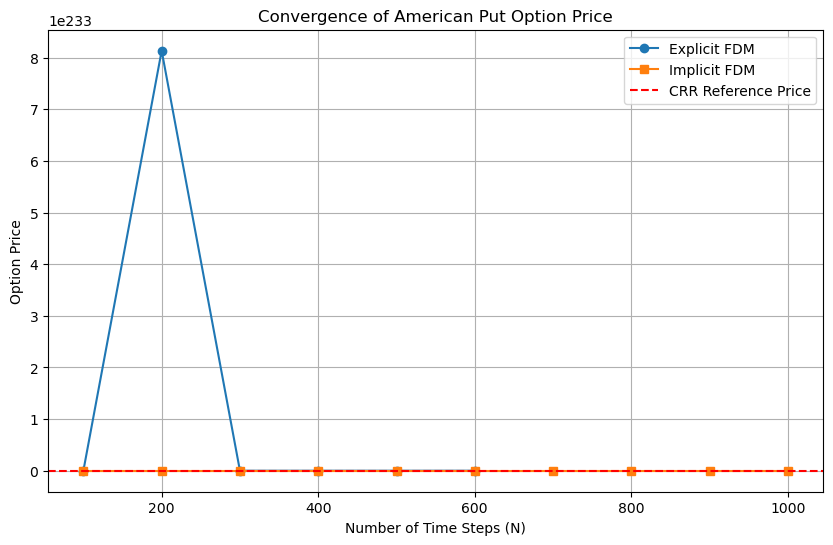

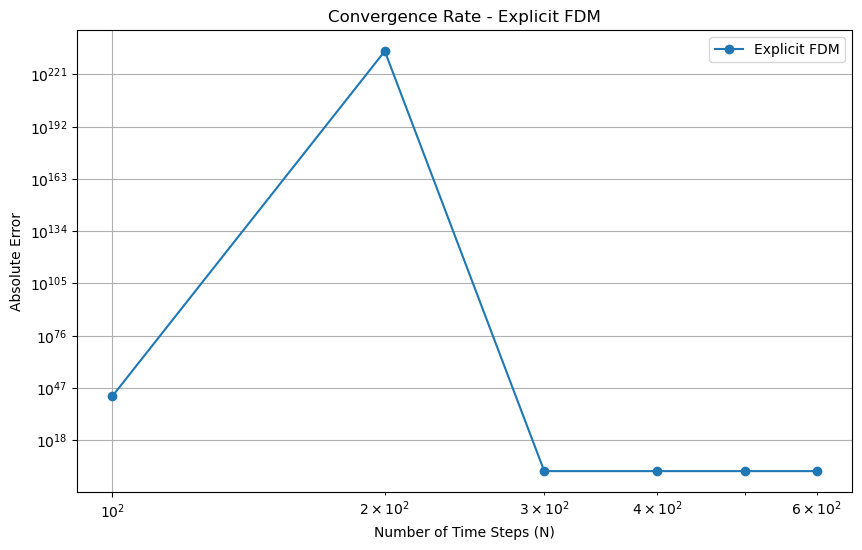

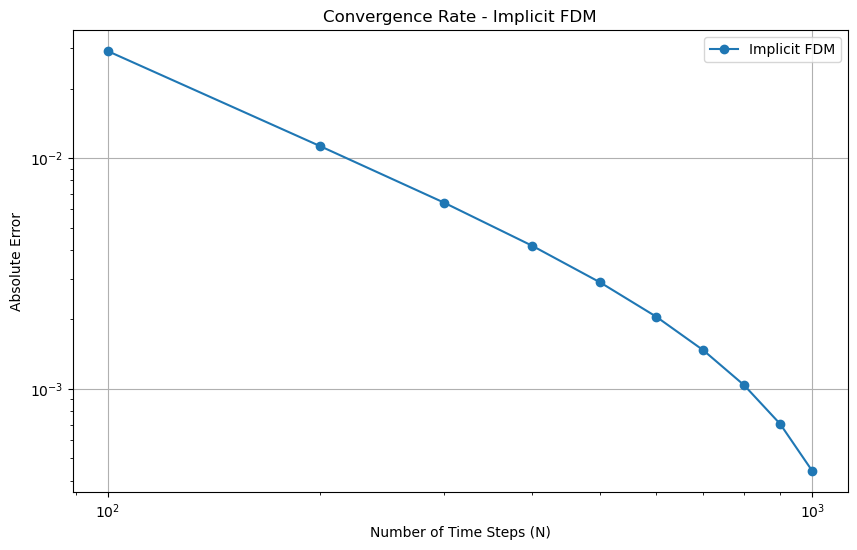

Estimated rate (Explicit): O(1/N^146.35)
Estimated rate (Implicit): O(1/N^1.74)


In [272]:
# Get results
Ns_exp, prices_exp, errors_exp = convergence_analysis_fdm(method='explicit', ref_price=crr_price)
Ns_imp, prices_imp, errors_imp = convergence_analysis_fdm(method='implicit', ref_price=crr_price)

# Plot results
plot_option_prices_vs_N(Ns_exp, prices_exp, Ns_imp, prices_imp)
plot_convergence_rate(Ns_exp, errors_exp, "Explicit FDM")
plot_convergence_rate(Ns_imp, errors_imp, "Implicit FDM")

# Estimate convergence rates
rate_exp = estimate_rate(Ns_exp, errors_exp)
rate_imp = estimate_rate(Ns_imp, errors_imp)

print(f"Estimated rate (Explicit): O(1/N^{rate_exp:.2f})")
print(f"Estimated rate (Implicit): O(1/N^{rate_imp:.2f})")


The convergence analysis of American Put option pricing using Finite Difference Methods reveals the following:

- Implicit FDM demonstrated stable and reliable convergence with an estimated rate of O(1/N^1.74), consistent with theoretical expectations  for implicit time-stepping schemes.

- Explicit FDM, on the other hand, showed an abnormally high estimated rate of O(1/N^146.35), indicating numerical instability or stagnation at low time steps followed by divergence. This highlights the sensitivity of the explicit method to parameter choices and the need for tighter stability conditions.

These results emphasize the superior robustness of the implicit method in practical American option pricing.

### Crank-Nicolson Finite Difference Method

In [303]:
import numpy as np

def american_put_crank_nicolson(S0, K, T, r, sigma, S_max=200, M=200, N=200, omega=1.2, tol=1e-6, max_iter=10000):
    dS = S_max / M
    dt = T / N
    S = np.linspace(0, S_max, M + 1)

    V = np.maximum(K - S, 0)  # Payoff at maturity
    V_old = V.copy()

    # Coefficients
    i = np.arange(1, M)
    a = 0.25 * dt * (sigma**2 * i**2 - r * i)
    b = -0.5 * dt * (sigma**2 * i**2 + r)
    c = 0.25 * dt * (sigma**2 * i**2 + r * i)

    A = -a
    B = 1 - b
    C = -c

    D = a
    E = 1 + b
    F = c

    for n in range(N):
        rhs = D * V_old[i - 1] + E * V_old[i] + F * V_old[i + 1]

        # Projected SOR for early exercise constraint
        V_new = V_old.copy()
        error = 1.0
        iter_count = 0

        while error > tol and iter_count < max_iter:
            V_temp = V_new.copy()
            for j in i:
                j_idx = j
                j_loc = j - 1
                Vj = (
                    A[j_loc] * V_new[j_idx - 1] +
                    B[j_loc] * V_new[j_idx] +
                    C[j_loc] * V_new[j_idx + 1]
                )
                Vj = (1 - omega) * V_new[j_idx] + (omega / B[j_loc]) * (rhs[j_loc] - A[j_loc] * V_new[j_idx - 1] - C[j_loc] * V_new[j_idx + 1])
                V_new[j_idx] = max(Vj, K - S[j_idx])  # early exercise condition

            error = np.linalg.norm(V_new - V_temp, ord=np.inf)
            iter_count += 1

        V_old = V_new.copy()
        V_old[0] = K  # Boundary condition
        V_old[M] = 0

    price = np.interp(S0, S, V_old)
    return price, S, V_old


        


In [304]:
S0 = 100
K = 100
T = 1.0
r = 0.03
sigma = 0.2
S_max = 3 * S0
M = 200  # Spatial steps
N = 1000  # Time steps


In [305]:
price_cn, S_grid, V_cn = american_put_crank_nicolson(S0, K, T, r, sigma)
print(f"American Put Option Price using Crank-Nicolson: {price_cn:.4f}")



American Put Option Price using Crank-Nicolson: 6.7400


Using Crank-Nicolson method the price of the put option is consistent with the other prices

#### Convergence Analysis

In [284]:
crr_price = 6.7411  # Reference from CRR method
Ns = range(50, 600, 50)
prices_cn, errors_cn = [], []

for N in Ns:
    price = american_put_crank_nicolson(S0, K, T, r, sigma, M=200, N=N)
    prices_cn.append(price)
    errors_cn.append(abs(price - crr_price))


<Figure size 1000x500 with 0 Axes>

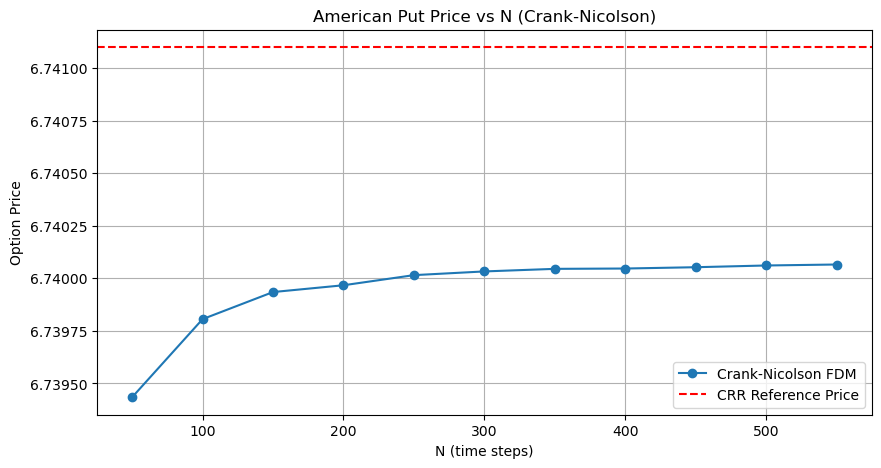

In [285]:
plt.figure(figsize=(10, 5))
plt.plot(Ns, prices_cn, marker='o', label='Crank-Nicolson FDM')
plt.axhline(y=crr_price, color='r', linestyle='--', label='CRR Reference Price')
plt.xlabel('N (time steps)')
plt.ylabel('Option Price')
plt.title('American Put Price vs N (Crank-Nicolson)')
plt.grid(True)
plt.legend()
plt.show()


In [286]:
log_N = np.log(Ns)
log_error = np.log(errors_cn)
slope, _ = np.polyfit(log_N, log_error, 1)
print(f"Estimated convergence rate for CN: O(1/N^{abs(slope):.2f})")


Estimated convergence rate for CN: O(1/N^0.18)


#### Early Exercise region

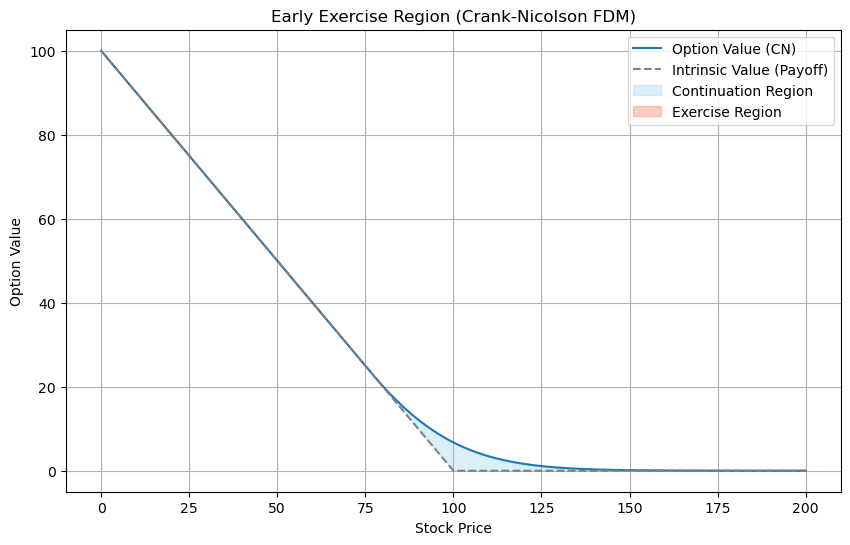

In [308]:
def plot_early_exercise_region(S, V, K, title="Early Exercise Region (Crank-Nicolson FDM)"):
    intrinsic = np.maximum(K - S, 0)

    plt.figure(figsize=(10, 6))
    plt.plot(S, V, label='Option Value (CN)')
    plt.plot(S, intrinsic, '--', label='Intrinsic Value (Payoff)', color='gray')
    
    # Highlight the continuation region
    plt.fill_between(S, V, intrinsic, where=(V > intrinsic), interpolate=True,
                     color='skyblue', alpha=0.3, label='Continuation Region')
    
    plt.fill_between(S, V, intrinsic, where=(V == intrinsic), interpolate=True,
                     color='salmon', alpha=0.4, label='Exercise Region')
    
    plt.xlabel("Stock Price")
    plt.ylabel("Option Value")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


plot_early_exercise_region(S_grid, V_cn, K)
